<a href="https://colab.research.google.com/github/gyq1985/deepmindset/blob/main/Google_Collab_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
data_path = "/content/drive/Shareddrives/Deepmindset/dataset/clean_dataset/images"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import shutil
import random

def split_dataset_into_train_val_test(original_dir, output_dir, train_ratio=0.7, val_ratio=0.10, test_ratio=0.20, seed=42):
    random.seed(seed)

    # Get class names (folder names in original dataset)
    classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

    for class_name in classes:
        class_dir = os.path.join(original_dir, class_name)
        images = os.listdir(class_dir)
        images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)

        # Calculate split sizes
        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        # Assign images to each split
        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        # Copy images to new directory structure
        for split, split_images in splits.items():
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src = os.path.join(class_dir, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

    print("Dataset successfully split into train / val / test!")

# Paths
original_data_dir = "/content/drive/Shareddrives/Deepmindset/dataset/clean_dataset/images"
output_data_dir = "/content/drive/Shareddrives/Deepmindset/dataset/split_dataset"

# Run splitting
split_dataset_into_train_val_test(original_data_dir, output_data_dir)


数据集划分完成！


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
!cp -r "/content/drive/Shareddrives/Deepmindset/dataset/split_dataset" /content/
# Set dataset path
data_path = "/content/split_dataset"
train_dir = data_path + "/train"
val_dir = data_path + "/val"
test_dir = data_path + "/test"

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation is applied only to the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data loader
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Validation data loader
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Test data loader
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3620 images belonging to 4 classes.
Found 588 images belonging to 4 classes.
Found 1151 images belonging to 4 classes.


In [6]:
# Build lightweight CNN with higher dropout
from tensorflow.keras import layers, models, Input

model = models.Sequential([
    Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Increased dropout
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [7]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)
# Compile model
model.compile(
    optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model with EarlyStopping
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 60s 478ms/step - accuracy: 0.3386 - loss: 1.8605 - val_accuracy: 0.5510 - val_loss: 1.0883
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 51s 446ms/step - accuracy: 0.4866 - loss: 1.2006 - val_accuracy: 0.5799 - val_loss: 0.9887
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 52s 453ms/step - accuracy: 0.5113 - loss: 1.1165 - val_accuracy: 0.5697 - val_loss: 0.9688
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 50s 443ms/step - accuracy: 0.5276 - loss: 1.0702 - val_accuracy: 0.6395 - val_loss: 0.8844
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 81s 437ms/step - accuracy: 0.5453 - loss: 1.0424 - val_accuracy: 0.6548 - val_loss: 0.8664
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 49s 429ms/step - accuracy: 0.5755 - loss: 1.0095 - val_accuracy: 0.6650 - val_loss: 0.8569
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 49s 427ms/step - accuracy: 0.5685 - loss: 0.9917 - val_accuracy: 0.6888 - val_loss: 0.8238
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 49s 430ms/step - accuracy: 0.5889 - loss: 0

In [8]:
loss, acc = model.evaluate(test_generator)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5726 - loss: 0.9524
Test loss: 0.7649
Test accuracy: 0.6742


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5726 - loss: 0.9524


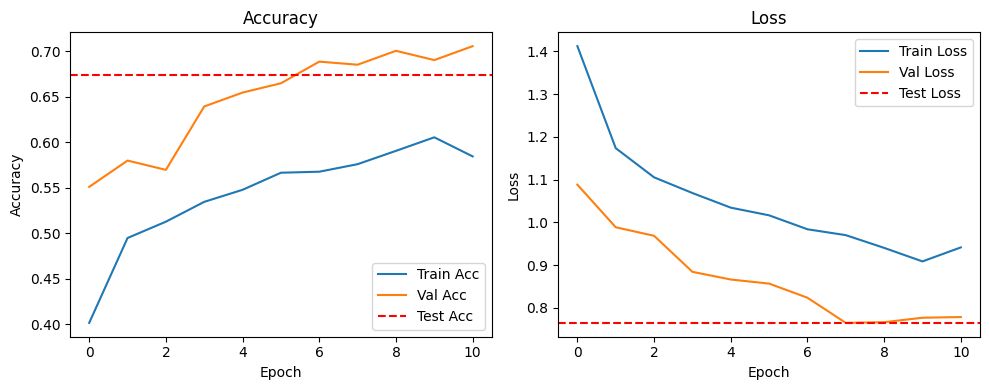

In [9]:

import matplotlib.pyplot as plt

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_generator)

# Plotting metrics
plt.figure(figsize=(10,4))

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step


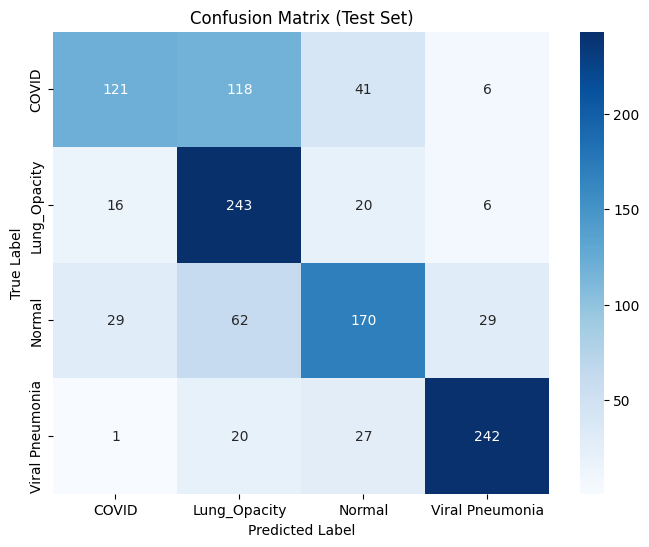

Classification Report (Test Set):

                 precision    recall  f1-score   support

          COVID       0.72      0.42      0.53       286
   Lung_Opacity       0.55      0.85      0.67       285
         Normal       0.66      0.59      0.62       290
Viral Pneumonia       0.86      0.83      0.84       290

       accuracy                           0.67      1151
      macro avg       0.70      0.67      0.67      1151
   weighted avg       0.70      0.67      0.67      1151



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reset the generator (to avoid any side effects from previous iterations)
test_generator.reset()

# True labels
Y_true = test_generator.classes

# Predicted labels
Y_pred = np.argmax(model.predict(test_generator), axis=1)

# Class label names
labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print("Classification Report (Test Set):\n")
print(classification_report(Y_true, Y_pred, target_names=labels))


In [11]:
# save model
# model.save("/content/drive/Shared drives/Deepmindset/model/cnn_poc_model.h5")
import keras
keras.saving.save_model(model, "/content/drive/Shared drives/Deepmindset/model/cnn_model.keras")